In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

# Remove folder in case it exists
!rm -rf /content/drive/MyDrive/ColabNotebooks/Team06_Project/Dataset06/dataset_6/

# Specify the path of the uploaded dataset in your Google Drive
dataset_path = "/content/drive/MyDrive/ColabNotebooks/Team06_Project/Dataset06/dataset_6.zip"

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip:
    zip.extractall("/content/drive/MyDrive/ColabNotebooks/Team06_Project/Dataset06/")

# **Dataset Preparation**

### Import Libraries

In [3]:
# imports

import os
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models
from sklearn.model_selection import train_test_split

### Features for Dataset

In [4]:
# Class Names and Class labels for the 2 classification
class_names = ['normal','covid']
# 0 = normal, 1 = Covid
class_labels = [0, 1]

### Data Exploration

In [5]:
dataset_dir = '/content/drive/MyDrive/ColabNotebooks/Team06_Project/Dataset06/'

# Initialize Count
normalCount=0
covidCount=0
imageCount=0

# Image size: 299 x 299 Pixels grayscale
image_size = (299, 299)

# Read image files - PNG
for class_name in class_names:
    for item in os.listdir(dataset_dir + f'/dataset_6/{class_name}/'):
        if item.endswith(".png"):

            # Check image size 299 x 299
            image_path = os.path.join(dataset_dir, 'dataset_6', class_name, item)
            # Raise Error if not correct size
            if Image.open(image_path).size != image_size:
                raise ValueError(f"The image size is not {image_size[0]} by {image_size[1]} pixels: {image_path}")

            # Increment Counter for images
            imageCount+=1
            if(class_name=='normal'):
                normalCount+=1
            else:
                covidCount+=1

print(f"Normal Count: {normalCount}\nCovid Count: {covidCount}\nTotal Count: {imageCount}\n")

Normal Count: 250
Covid Count: 180
Total Count: 430



### Create Dataset for Training Model

In [6]:
# np array for images. 430 images, 299 pixel, 299 pixels
images = np.empty((imageCount,image_size[0],image_size[1]))
# np arraay for image labels, 430 labels
labels = np.empty((imageCount,1))

# Index for assigning image to np array loction
index=0

# Loop Through normal/covid img folders
for label,class_name in enumerate(class_names):
    # Iterate through items in folder
    for item in os.listdir(dataset_dir + f'/dataset_6/{class_name}/'):
        # if item is png image
        if item.endswith(".png"):
            image_path = dataset_dir + f'/dataset_6/{class_name}/{item}'
            # Read item into np array
            image = np.array(Image.open(image_path))
            # Normalize image from 0-255, to 0 to 1
            image = image/255
            # Add image to np array
            images[index]=image
            # Add label to np array
            labels[index]=label
            index+=1
# Convert labels to INT
labels=np.array(labels,dtype=np.int32)

### Split Dataset into Training & Testing Dataset

In [7]:
#Fixed seed
seed = 88
# Train Test Split for training machine learning and Deep Learning
# Split percentage 80% for train, 20% for test.
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=seed
)

# Get the number of samples in the training dataset
num_train_samples = len(train_images)

print("Number of samples in the training dataset:", num_train_samples)

Number of samples in the training dataset: 344


### Visualize Training Dataset

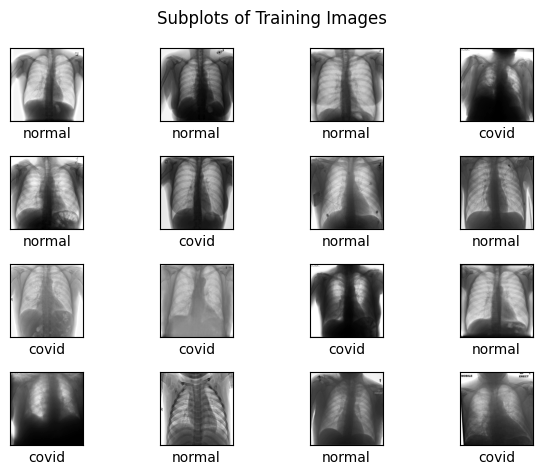

In [8]:
#Visualize new dataset of both covid and normal lungs
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.subplots_adjust(top=0.9)
plt.suptitle("Subplots of Training Images")
plt.tight_layout()
plt.show()

# **K-NN**

### Import Libraries

In [9]:
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from skimage.feature import hog
from math import sqrt
import numpy as np

In [10]:
# Get the number of features (dimensions) in each image
num_features = np.prod(images.shape[1:])

print("Number of features (dimensions) in each image:", num_features)

Number of features (dimensions) in each image: 89401


In [11]:
# Flatten the images
train_images_flattened = train_images.reshape(len(train_images), -1)

print(train_images_flattened)

[[0.84313725 0.67058824 0.46666667 ... 0.10980392 0.10980392 0.09411765]
 [0.00392157 0.00392157 0.00392157 ... 0.04313725 0.04705882 0.04313725]
 [1.         1.         1.         ... 0.10588235 0.10980392 0.09803922]
 ...
 [0.03529412 0.03529412 0.03529412 ... 0.00784314 0.00784314 0.00784314]
 [0.27058824 0.24313725 0.19607843 ... 0.76862745 0.73333333 0.71764706]
 [0.35294118 0.34117647 0.3254902  ... 0.63137255 0.61568627 0.6       ]]


### Feature Extraction (PCA)

In [12]:
def pca_feature_extraction(train_images, num_components_to_keep=None):
    """
    Perform PCA to extract features from the training images.

    Parameters:
        train_images (numpy.ndarray): A 3D numpy array representing the training images.
                                     Shape: (num_samples, height, width).
        num_components_to_keep (int or None): The number of components to keep after PCA.
                                              If None, the optimal number will be determined.
        seed (int or None): Random seed for reproducibility.

    Returns:
        numpy.ndarray: Transformed training images after PCA.
        PCA: The fitted PCA object.
        int: The number of components kept after PCA.
    """
    if num_components_to_keep is None:
        # Perform PCA to determine the optimal number of components
        pca = PCA()
        pca.fit(train_images_flattened)

        # Calculate the explained variance ratio for each component
        explained_variances = pca.explained_variance_ratio_

        # Choose the number of components where the explained variance accumulates up to a certain threshold
        cumulative_variances = np.cumsum(explained_variances)
        num_components_to_keep = np.argmax(cumulative_variances >= 0.95) + 1

    # Perform PCA with the chosen number of components
    pca = PCA(n_components=num_components_to_keep)
    train_images_pca = pca.fit_transform(train_images_flattened)

    return train_images_pca, pca, num_components_to_keep

# Perform PCA-based feature extraction on the training and test images
train_features, pca_object, optimal_n_components = pca_feature_extraction(train_images_flattened)

# Perform PCA-based feature extraction on the test images using the same PCA object from training
test_features = pca_object.transform(test_images.reshape(len(test_images), -1))

# Print the optimal number of components found
print("Optimal number of components:", optimal_n_components)

Optimal number of components: 93


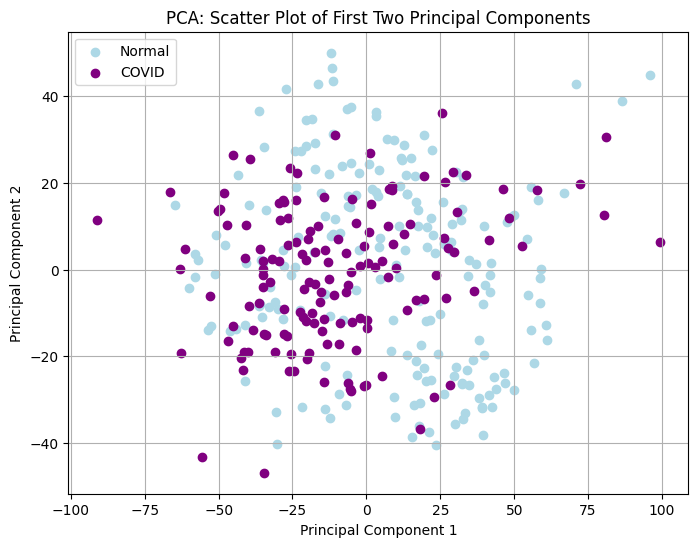

In [13]:
# Convert labels to 1D arrays
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

def plot_pca_scatter(features, labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='lightblue', label='Normal')
    plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='purple', label='COVID')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: Scatter Plot of First Two Principal Components')
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot PCA scatter plot for the transformed training features
plot_pca_scatter(train_features[:, :2], train_labels)

#### Find Optimal k Value

Best k value: 5


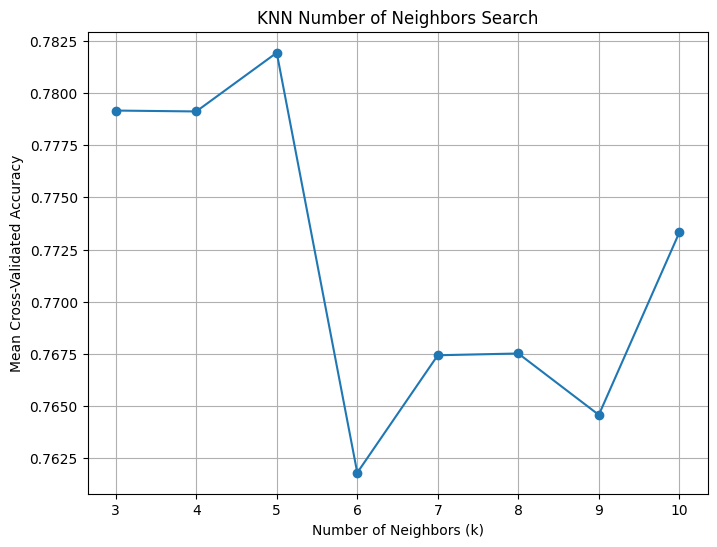

In [14]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a dictionary of hyperparameters to search
param_grid = {'n_neighbors': np.arange(3, 11)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features, train_labels)

# Get the best k value from the grid search
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

# Get the mean cross-validated accuracy for each k value
mean_scores = grid_search.cv_results_['mean_test_score']

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(param_grid['n_neighbors'], mean_scores, marker='o')
plt.title("KNN Number of Neighbors Search")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Cross-Validated Accuracy")
plt.grid(True)
plt.show()

### Fit & Predict the Model

In [15]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(5)
knn.fit(train_features, train_labels)

# Make predictions on the test set after PCA
predictions = knn.predict(test_features)

### Evaluate

Confusion Matrix:
[[39 11]
 [ 5 31]]


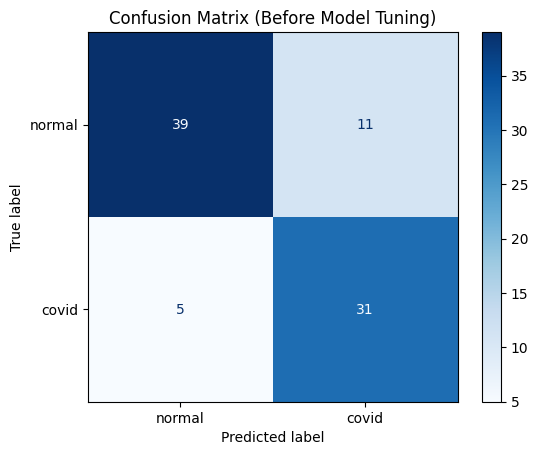

Classification Report:
              precision    recall  f1-score   support

      normal       0.89      0.78      0.83        50
       covid       0.74      0.86      0.79        36

    accuracy                           0.81        86
   macro avg       0.81      0.82      0.81        86
weighted avg       0.82      0.81      0.82        86



In [24]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
classes = np.unique(test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Before Model Tuning)")
plt.show()

# Compute classification report
report = classification_report(test_labels, predictions, target_names=class_names)
print("Classification Report:")
print(report)

In [17]:
# Predict on both training and test sets
train_predictions = knn.predict(train_features)
test_predictions = knn.predict(test_features)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Calculate accuracy on the test set for
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8517441860465116
Test Accuracy: 0.813953488372093


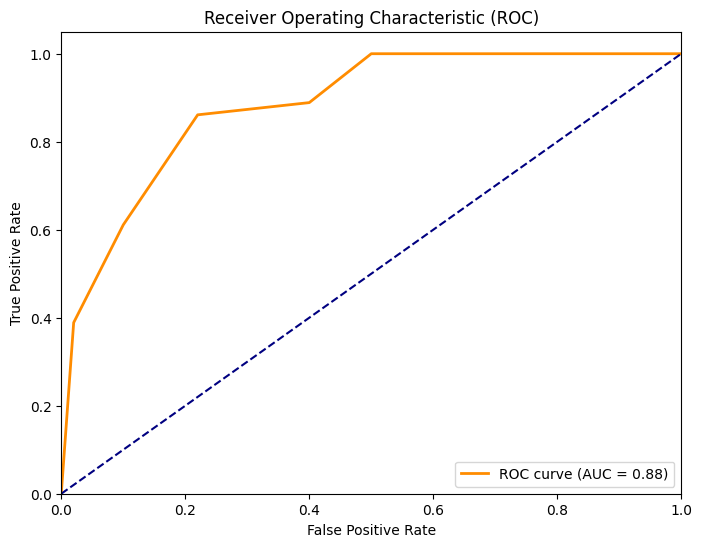

Area Under the Curve (AUC): 0.8841666666666667
False Positive Rate (FPR): [0.   0.02 0.1  0.22 0.4  0.5  1.  ]
True Positive Rate (TPR): [0.         0.38888889 0.61111111 0.86111111 0.88888889 1.
 1.        ]
Thresholds: [2.  1.  0.8 0.6 0.4 0.2 0. ]


In [18]:
test_probabilities = knn.predict_proba(test_features)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Area Under the Curve (AUC):", roc_auc)
print("False Positive Rate (FPR):", fpr)
print("True Positive Rate (TPR):", tpr)
print("Thresholds:", thresholds)

# **K-NN Enhancement**

### Import Libraries

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [20]:
# np array for images. 430 images, 299 pixel, 299 pixels
images = np.empty((imageCount, image_size[0], image_size[1]))
# np array for image labels, 430 labels
labels = np.empty((imageCount, 1))

# Index for assigning image to np array location
index = 0

# Loop Through normal/covid img folders
for label, class_name in enumerate(class_names):
    # Iterate through items in folder
    for item in os.listdir(dataset_dir + f'/dataset_6/{class_name}/'):
        # if item is png image
        if item.endswith(".png"):
            image_path = dataset_dir + f'/dataset_6/{class_name}/{item}'
            # Read item into np array
            image = np.array(Image.open(image_path))
            # Add image to np array
            images[index] = image
            # Add label to np array
            labels[index] = label
            index += 1

# Convert labels to INT
labels = np.array(labels, dtype=np.int32)

# Flatten the images to a 2D array
images_flattened = images.reshape(len(images), -1)

# Fixed seed
seed = 88
# Train Test Split for training machine learning and Deep Learning
# Split percentage 80% for train, 20% for test.
train_images, test_images, train_labels, test_labels = train_test_split(
    images_flattened, labels, test_size=0.2, random_state=seed
)

# Flatten the train_labels and test_labels to 1D arrays
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

### Different Distance Metrics & Scaler

In [21]:
# Define the hyperparameter grid
param_grid = {'n_neighbors': np.arange(1, 11),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'brute'],
              'metric': ['euclidean', 'manhattan','cosine', 'canberra', 'braycurtis']}

# Define the KNN classifier
knn = KNeighborsClassifier()

# List of scalers to compare
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

for scaler in scalers:
    print(f"Using {scaler.__class__.__name__}:")

    # Preprocess the data - scale the images using selected scaler on the training set
    train_images_scaled = scaler.fit_transform(train_images)
    # Scale the test set
    test_images_scaled = scaler.transform(test_images)

    # Perform PCA to extract features from the scaled data
    train_features_scaled, pca_object, num_components_kept = pca_feature_extraction(train_images_scaled)
    test_features_scaled = pca_object.transform(test_images_scaled)
    # Print the optimal number of components found
    print("Optimal number of components:", num_components_kept)

    # Define the grid search object
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

    # Fit the grid search object to the scaled training data
    grid.fit(train_features_scaled, train_labels)

    # Print the best hyperparameters and corresponding accuracy
    print("Best Hyperparameters:", grid.best_params_)
    print("Best Accuracy:", grid.best_score_)

    # Train the model with the best hyperparameters on the training set
    best_knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'],
                                    weights=grid.best_params_['weights'],
                                    algorithm=grid.best_params_['algorithm'],
                                    metric=grid.best_params_['metric'])

    best_knn.fit(train_features_scaled, train_labels)

    # Predict on both training and test sets
    train_predictions = best_knn.predict(train_features_scaled)
    test_predictions = best_knn.predict(test_features_scaled)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print("K-NN Test Accuracy:", test_accuracy)
    print("-----------------------------------------------------------------------------------")

Using StandardScaler:
Optimal number of components: 93
Best Hyperparameters: {'algorithm': 'auto', 'metric': 'braycurtis', 'n_neighbors': 7, 'weights': 'uniform'}
Best Accuracy: 0.8286018755328218
K-NN Test Accuracy: 0.7558139534883721
-----------------------------------------------------------------------------------
Using MinMaxScaler:
Optimal number of components: 93
Best Hyperparameters: {'algorithm': 'auto', 'metric': 'braycurtis', 'n_neighbors': 8, 'weights': 'distance'}
Best Accuracy: 0.8314151747655583
K-NN Test Accuracy: 0.8372093023255814
-----------------------------------------------------------------------------------
Using RobustScaler:
Optimal number of components: 93
Best Hyperparameters: {'algorithm': 'auto', 'metric': 'braycurtis', 'n_neighbors': 3, 'weights': 'uniform'}
Best Accuracy: 0.8284739982949703
K-NN Test Accuracy: 0.7093023255813954
-----------------------------------------------------------------------------------


Optimal number of components: 93
Confusion Matrix:
[[43  7]
 [ 7 29]]


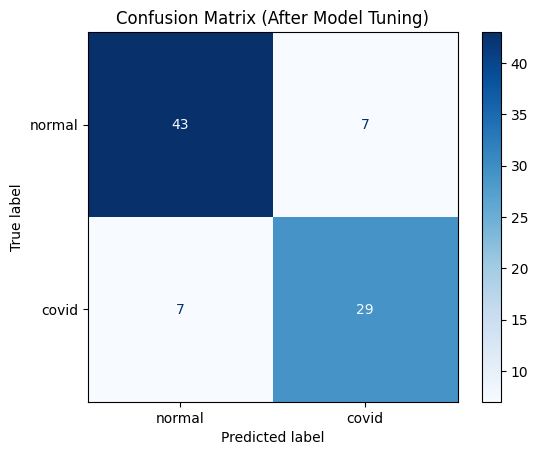

Classification Report:
              precision    recall  f1-score   support

      normal       0.86      0.86      0.86        50
       covid       0.81      0.81      0.81        36

    accuracy                           0.84        86
   macro avg       0.83      0.83      0.83        86
weighted avg       0.84      0.84      0.84        86

Training Accuracy: 0.8488372093023255
Test Accuracy: 0.8372093023255814


In [27]:
# Scale the features using StandardScaler
scaler_min_max  = MinMaxScaler()
train_images_scaled = scaler_min_max.fit_transform(train_images)
test_images_scaled = scaler_min_max.transform(test_images)

# Perform PCA to extract features from the scaled data
train_features_scaled, pca_object, num_components_kept = pca_feature_extraction(train_images_scaled)
test_features_scaled = pca_object.transform(test_images_scaled)
# Print the optimal number of components found
print("Optimal number of components:", num_components_kept)

# Create and train the KNN classifier
best_knn = KNeighborsClassifier(n_neighbors=8, metric='braycurtis')
best_knn.fit(train_features_scaled, train_labels)

# Predict on both training and test sets
train_predictions = best_knn.predict(train_features_scaled)
test_predictions = best_knn.predict(test_features_scaled)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
classes = np.unique(test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (After Model Tuning)")
plt.show()

# Compute classification report
report = classification_report(test_labels, test_predictions, target_names=class_names)
print("Classification Report:")
print(report)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)